# Titanic

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
get_ipython().magic(u'matplotlib inline')

df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


## Data Exploration and Cleaning

In [2]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Missing values in column Age, Cabin and Embarked

### drop column PassengerId, Ticket, Cabin , for they seems not very useful

In [4]:
df.drop(['PassengerId','Ticket','Cabin'], inplace=True, axis=1)

In [5]:
df.describe()

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,NaN,0.000000,0.000000,7.910400
50%,0.000000,3.000000,NaN,0.000000,0.000000,14.454200
75%,1.000000,3.000000,NaN,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1051833d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x108023150>]], dtype=object)

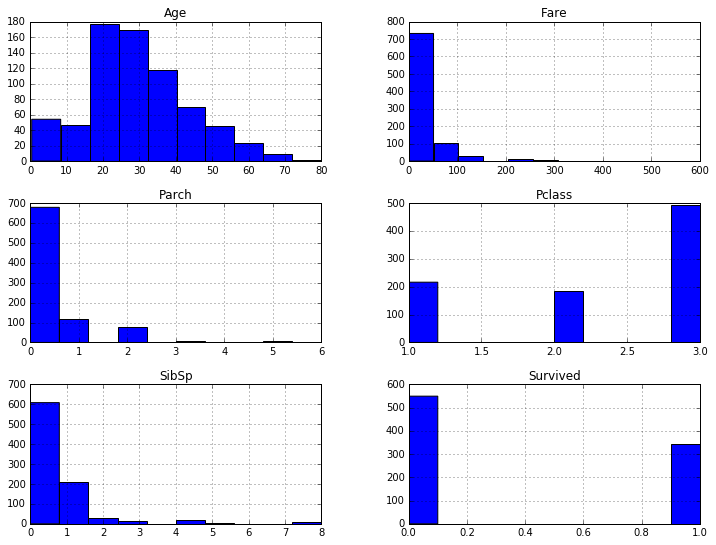

In [6]:
df.hist(figsize=(12,9
                ))

OrderedDict([('Survived',
              {'boxes': [<matplotlib.lines.Line2D at 0x108a37b10>],
               'caps': [<matplotlib.lines.Line2D at 0x108a49a10>,
               'fliers': [<matplotlib.lines.Line2D at 0x108a53d10>],
               'means': [],
               'medians': [<matplotlib.lines.Line2D at 0x108a536d0>],
               'whiskers': [<matplotlib.lines.Line2D at 0x108a37cd0>,
                <matplotlib.lines.Line2D at 0x108a493d0>]}),
             ('Pclass',
              {'boxes': [<matplotlib.lines.Line2D at 0x108a60850>],
               'caps': [<matplotlib.lines.Line2D at 0x108a6d710>,
               'fliers': [<matplotlib.lines.Line2D at 0x108a78a10>],
               'means': [],
               'medians': [<matplotlib.lines.Line2D at 0x108a783d0>],
               'whiskers': [<matplotlib.lines.Line2D at 0x108a609d0>,
                <matplotlib.lines.Line2D at 0x108a6d0d0>]}),
             ('Age',
              {'boxes': [<matplotlib.lines.Line2D at 0x108a84550>

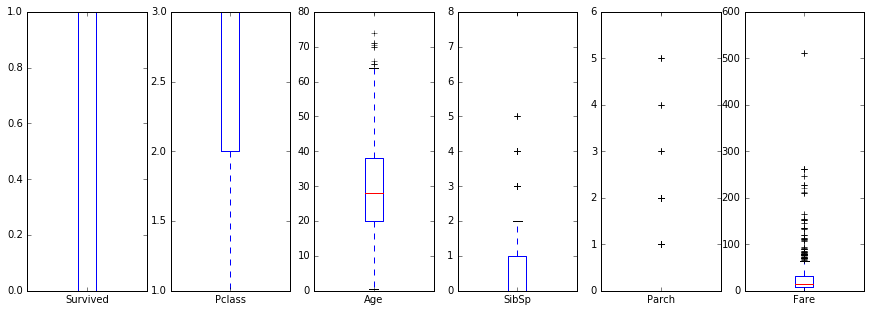

In [7]:
df.plot(kind='box', return_type='dict' , subplots = True, figsize=(15,5))

### Outliers exist in Age, SibSp, Fare, how do we want to treat them?

### fill the missing values in Age with median values. do we have a better way?

In [8]:
median_age = df.Age.median()
df['Age'].fillna(median_age, inplace = True)

### treat the missing values in Embarked

In [9]:
df[df.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
61,1,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,NaN
829,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,NaN


In [10]:
# check Embarked values
df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

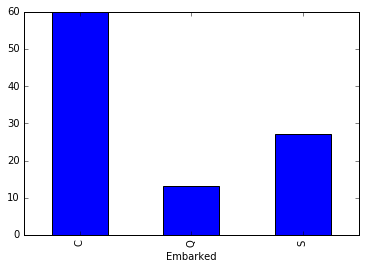

In [11]:
df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [12]:
# it seems that based on Fare-Embarked relationship, the missing values are likely C.
df.Embarked.fillna('C', inplace=True)

In [13]:
df.Embarked = df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [14]:
df.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

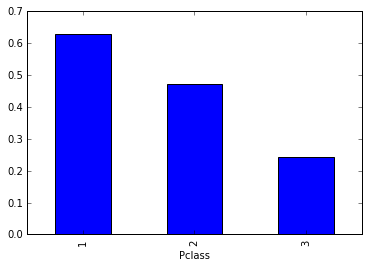

In [15]:
df.pivot_table(values='Survived',
               index=['Pclass'],
               aggfunc=np.mean).plot(kind='bar')

Pclass 1 and 2 have much better chance of surviving than Pclass 3.
However, this would have been factored in tree based models.

In [16]:
df['Pclass1']=df.Pclass == 1
df['Pclass2']=df.Pclass == 2

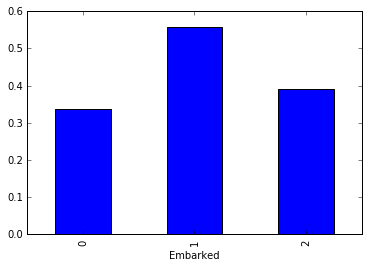

In [17]:
df.pivot_table(values='Survived',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [18]:
df['FamilySize'] = df['SibSp'] + df['Parch']

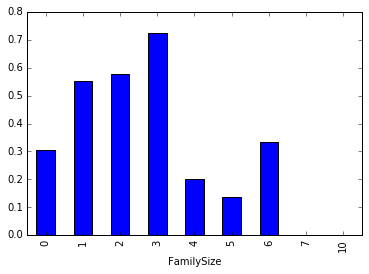

In [19]:
df.pivot_table(values='Survived',
               index=['FamilySize'],
               aggfunc=np.mean).plot(kind='bar')

In [20]:
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Pclass1,Pclass2,FamilySize
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,0,False,False,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,1,True,False,1
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,0,False,False,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,0,True,False,1
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,0,False,False,0


In [21]:
adult_age = 16
df['Person'] = df[['Age','Sex']].apply(lambda x: 'child' if x[0]<adult_age else x[1], axis=1)
# first convert to str, then map
df.Person = df.Person.astype(str).map({'male':1,'female':0,'child':2})

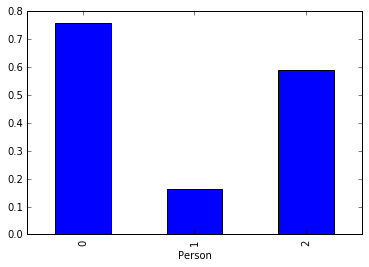

In [22]:
df.pivot_table(values='Survived',
               index=['Person'],
               aggfunc=np.mean).plot(kind='bar')

In [23]:
df.Person.value_counts()

1    537
0    271
2     83
Name: Person, dtype: int64

In [24]:
# according to the women and child first policy,
# if the wife died, it is likely the whole family died
# and if the husband died, it is likely the whole family survived

# theoretically a great tree based algorithm should discover this on its own, but
# new features like these are provided to ML as cue to narrow its search

df['surname'] = df['Name'].apply(lambda name: name.split(',')[0].lower())

perishing_female_surnames = df[(df.Person==0) & (df.Survived ==0) & (df.FamilySize > 0)]['surname'].unique()
print('Total female adult victims with family:', len(perishing_female_surnames))

('Total female adult victims with family:', 30)


In [25]:
df['perish_mother_wife'] = df['surname'].apply(lambda x: 1 if x in perishing_female_surnames else 0)


In [26]:
survive_male_surnames = df[(df.Person==1) & (df.Survived ==1) & (df.FamilySize > 0)]['surname'].unique()

In [27]:
df['survive_father_husband'] = df['surname'].apply(lambda x: 1 if x in survive_male_surnames else 0)


In [28]:
# finish up and predict

df.drop(['SibSp','Parch','Name','surname','Sex','Age'],axis=1, inplace=True)

In [29]:
predictor_var = list(df.columns[1:])
print predictor_var
outcome_var = 'Survived'

['Pclass', 'Fare', 'Embarked', 'Pclass1', 'Pclass2', 'FamilySize', 'Person', 'perish_mother_wife', 'survive_father_husband']


In [30]:
#categorical = ['Pclass', 'Person','Embarked','perish_mother_wife','survive_father_husband']
categorical = ['Pclass1', 'Pclass2', 'Person','Embarked','perish_mother_wife','survive_father_husband']
non_categorical = [ i for i in predictor_var if i not in categorical ]

In [31]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_cat = ohe.fit_transform(df[categorical])

In [32]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_non_cat = sc.fit_transform(df[non_categorical])

In [33]:
from numpy import hstack
X = hstack((X_non_cat, X_cat))
y = df[outcome_var]
X.shape, X_non_cat.shape, X_cat.shape

((891, 17), (891, 3), (891, 14))

In [ ]:
# dimension reduction then plot
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
X_prime = pca.fit_transform(X)

In [34]:
from sklearn.model_selection import learning_curve
# http://scikit-learn.org/stable/modules/generated\
#/sklearn.model_selection.learning_curve.html#sklearn.model_selection.learning_curve

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), scoring='accuracy'):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression()
scores = cross_val_score(lr_model, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} lr_model".format(scores.mean(), scores.std())

Accuracy: 88.656% +/-2.47% lr_model


In [36]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, max_depth=6)
#print rf_model.get_params()
scores = cross_val_score(rf_model, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} rf_model".format(scores.mean(), scores.std())

Accuracy: 88.322% +/-2.73% rf_model


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

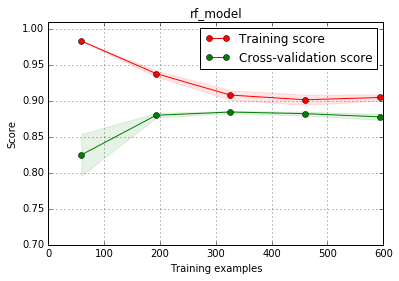

In [37]:
plot_learning_curve(rf_model, "rf_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [38]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} knn".format(scores.mean(), scores.std())

Accuracy: 86.549% +/-5.77% knn


In [39]:
from sklearn import svm
svm_model = svm.SVC(kernel='rbf', random_state=0, gamma=0.10, C=1)
scores = cross_val_score(svm_model, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} svm_model".format(scores.mean(), scores.std())

Accuracy: 88.656% +/-2.76% svm_model


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

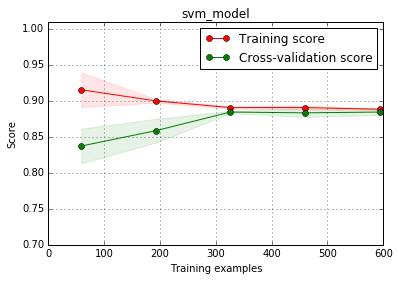

In [40]:
plot_learning_curve(svm_model, "svm_model", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [41]:
from sklearn.ensemble import AdaBoostClassifier

adaboost = AdaBoostClassifier(n_estimators=100)
scores = cross_val_score(adaboost, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.2%} +/-{:.2%} adaboost".format(scores.mean(), scores.std())

Accuracy: 87.98% +/-2.63% adaboost


In [42]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
scores = cross_val_score(gnb, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} GaussianNB".format(scores.mean(), scores.std())

Accuracy: 82.288% +/-4.68% GaussianNB


In [43]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

xgb = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555)
scores = cross_val_score(xgb, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} xgb".format(scores.mean(), scores.std())

/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Accuracy: 88.545% +/-2.95% xgb


In [44]:
from sklearn.model_selection import GridSearchCV

param_test1 = {
    "max_depth": (1,2,3),
    "min_child_weight": (1,2,3)
}

gsearch1 = GridSearchCV(estimator = xgb, 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,cv=10, verbose=0)

gsearch1.fit(X, y)
#gsearch1.cv_results_, 
gsearch1.best_params_, gsearch1.best_score_

({'max_depth': 2, 'min_child_weight': 1}, 0.88888888888888884)

In [76]:
max_depth, min_child_weight = gsearch1.best_params_.values()

In [78]:
param_test = {
    "subsample": (.6,.75,.9),
    "colsample_bytree": (.6,.75,.9)
}

gsearch = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=max_depth,
 min_child_weight=min_child_weight,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555), 
 param_grid = param_test, scoring='accuracy',n_jobs=4,cv=10, verbose=0)

gsearch.fit(X, y)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.6, 'subsample': 0.75}, 0.88888888888888884)

In [81]:
colsample_bytree = gsearch.best_params_['colsample_bytree']
subsample = gsearch.best_params_['subsample']

In [83]:
param_test = {
    "gamma": (1e-5,.1, 0,10, 1e5),
}

gsearch = GridSearchCV(estimator = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=max_depth,
 min_child_weight=min_child_weight,
 gamma=0,
 subsample=subsample,
 colsample_bytree=colsample_bytree,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555), 
 param_grid = param_test, scoring='accuracy',n_jobs=4,cv=10, verbose=0)

gsearch.fit(X, y)
gsearch.best_params_, gsearch.best_score_

({'gamma': 1e-05}, 0.88888888888888884)

In [84]:
xgb2 = XGBClassifier(
 learning_rate =0.01,
 n_estimators=1000,
 max_depth=max_depth,
 min_child_weight=min_child_weight,
 gamma=1e-5,
 subsample=subsample,
 colsample_bytree=colsample_bytree,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555)
scores = cross_val_score(xgb2, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} xgb".format(scores.mean(), scores.std())

Accuracy: 88.882% +/-2.46% xgb


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

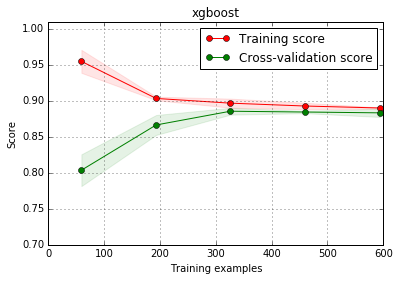

In [85]:
plot_learning_curve(xgb2, "xgboost", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [49]:
from sklearn.ensemble import VotingClassifier
eclf = VotingClassifier(estimators=[('rf', rf_model), ('svm', svm_model),('xgb', xgb2)], voting='hard')

scores = cross_val_score(eclf, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} eclf".format(scores.mean(), scores.std())

Accuracy: 88.770% +/-2.68% eclf


/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)
/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:540: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


<module 'matplotlib.pyplot' from '/Users/mingyuzhu/git/venv/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

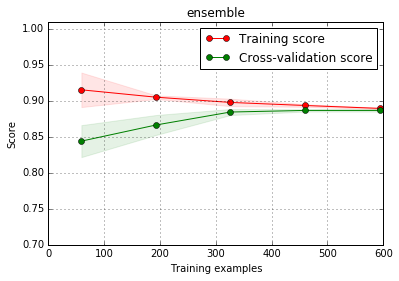

In [50]:
plot_learning_curve(eclf, "ensemble", X, y, ylim=(0.7, 1.01), n_jobs=4)

In [51]:

"""
import tensorflow as tf
# Build 3 layer DNN with 1024, 512, 256 units respectively.
dnn = tf.contrib.learn.DNNClassifier(hidden_units=[1024,512,256],
n_classes=99)

scores = cross_val_score(dnn, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.3%} +/-{:.2%} eclf".format(scores.mean(), scores.std())

# Fit model.
dnn.fit(x=x_train, y=y_train, steps = 2000)

# Make prediction for test data
y = dnn.predict(x_test)
"""

'\nimport tensorflow as tf\n# Build 3 layer DNN with 1024, 512, 256 units respectively.\ndnn = tf.contrib.learn.DNNClassifier(hidden_units=[1024,512,256],\nn_classes=99)\n\nscores = cross_val_score(dnn, X, y, cv=10, scoring=\'accuracy\')\nprint "Accuracy: {:.3%} +/-{:.2%} eclf".format(scores.mean(), scores.std())\n\n# Fit model.\ndnn.fit(x=x_train, y=y_train, steps = 2000)\n\n# Make prediction for test data\ny = dnn.predict(x_test)\n'

In [52]:
""" really slow
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(rf_model,
                            max_samples=0.5, max_features=0.5)
scores = cross_val_score(bagging, X, y, cv=10, scoring='accuracy')
print "Accuracy: {:.2%} +/-{:.2%} bagging".format(scores.mean(), scores.std())
"""

' really slow\nfrom sklearn.ensemble import BaggingClassifier\n\nbagging = BaggingClassifier(rf_model,\n                            max_samples=0.5, max_features=0.5)\nscores = cross_val_score(bagging, X, y, cv=10, scoring=\'accuracy\')\nprint "Accuracy: {:.2%} +/-{:.2%} bagging".format(scores.mean(), scores.std())\n'

In [53]:

from sklearn import cross_validation, metrics   #Additional scklearn functions

from sklearn.cross_validation import train_test_split

"""
def modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        dtrain = xgb.DMatrix(X,label=y)
        cvresult = xgb.cv(xgb_param,
                          dtrain,
                          num_boost_round=alg.get_params()['n_estimators'],
                          nfold=cv_folds,
                          metrics='error', # no accuracy
                          callbacks=[xgb.callback.print_evaluation(show_stdv=False),
                                     xgb.callback.early_stop(early_stopping_rounds)]
                         )
        
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X, y,eval_metric='error')
        
    #Predict training set:
    dtrain_predictions = alg.predict(X)
    dtrain_predprob = alg.predict_proba(X)[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(y.values, dtrain_predictions)
    #print "AUC Score (Train): %f" % metrics.roc_auc_score(y, dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=100,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 #reg_alpha = .01,
 #reg_lambda = .01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=555)

#modelfit(xgb1, X, y)
"""

'\ndef modelfit(alg, X, y, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):\n    if useTrainCV:\n        xgb_param = alg.get_xgb_params()\n        dtrain = xgb.DMatrix(X,label=y)\n        cvresult = xgb.cv(xgb_param,\n                          dtrain,\n                          num_boost_round=alg.get_params()[\'n_estimators\'],\n                          nfold=cv_folds,\n                          metrics=\'error\', # no accuracy\n                          callbacks=[xgb.callback.print_evaluation(show_stdv=False),\n                                     xgb.callback.early_stop(early_stopping_rounds)]\n                         )\n        \n        alg.set_params(n_estimators=cvresult.shape[0])\n    \n    #Fit the algorithm on the data\n    alg.fit(X, y,eval_metric=\'error\')\n        \n    #Predict training set:\n    dtrain_predictions = alg.predict(X)\n    dtrain_predprob = alg.predict_proba(X)[:,1]\n        \n    #Print model report:\n    print "\nModel Report"\n    print "Accura

In [54]:
# now work on test data
test_df.apply(lambda x: x.isnull().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [55]:
test_df.Age.fillna(test_df.Age.median(), inplace=True)

In [56]:
test_df[test_df.Fare.isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


In [57]:
test_df.Embarked = test_df.Embarked.astype(str).map({"S":0,"C":1,"Q":2})

In [58]:
mean_fare = test_df[test_df.Embarked==0]['Fare'].mean() ; mean_fare

28.230436431226767

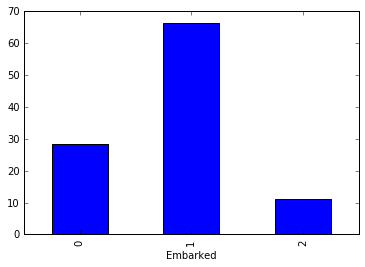

In [59]:
test_df.pivot_table(values='Fare',
               index=['Embarked'],
               aggfunc=np.mean).plot(kind='bar')

In [60]:
test_df.Fare.fillna(mean_fare, inplace = True)

In [61]:
test_df['FamilySize'] = test_df.SibSp + test_df.Parch


In [62]:
test_df['Person'] = test_df[['Age','Sex']].apply(lambda x: 'child' if x[0]<adult_age else x[1], axis=1)
# first convert to str, then map
test_df.Person = test_df.Person.astype(str).map({'male':1,'female':0,'child':2})


In [63]:
# additional features

test_df['surname'] = test_df['Name'].apply(lambda name: name.split(',')[0].lower())

test_df['perish_mother_wife'] = test_df['surname'].apply(lambda x: 1 if x in perishing_female_surnames else 0)
test_df['survive_father_husband'] = test_df['surname'].apply(lambda x: 1 if x in survive_male_surnames else 0)


In [64]:
test_df['Pclass1'] = test_df.Pclass==1
test_df['Pclass2'] = test_df.Pclass==2

In [65]:
test_df.drop(['Name','surname','Sex','Age','SibSp','Parch','Ticket','Cabin'], inplace=True, axis=1)
test_df[:3]

,PassengerId,Pclass,Fare,Embarked,FamilySize,Person,perish_mother_wife,survive_father_husband,Pclass1,Pclass2
0,892,3,7.8292,2,0,1,0,0,False,False
1,893,3,7.0000,0,1,0,0,0,False,False
2,894,2,9.6875,2,0,1,0,0,False,True


In [66]:
# encoding, standarize
X_test_cat = ohe.transform(test_df[categorical])
X_test_non_cat = sc.transform(test_df[non_categorical])
X_test = hstack((X_test_non_cat, X_test_cat))

In [86]:
model = xgb2
model.fit(X,y)
Y_pred = model.predict(X_test)
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('./submissions/xgb6.csv', index=False)